## limpiar datos de absorbancia – AIlly

En esta celda limpiamos el archivo original en formato `.txt` con datos de absorbancia de café Illy - AIlly a una sola matriz `.csv` con datos limpios y lista para analizar.


  - Las filas son longitudes de onda (`nm`)
  - Las dos columnas corresponden a nm y absorbancia de la muestra, respectivamente.

El resultado se guarda en un archivo llamado `AIlly_matrix.csv`

In [1]:
import pandas as pd
import os
import re

# Detectamos los archivos .txt válidos (los que tienen datos de absorbancia)
archivos_txt = [f for f in os.listdir() if f.endswith('.txt') and f != 'AOxMM.csv']

# Función para extraer gramaje del nombre del archivo
def extraer_gramos(nombre):
    match = re.search(r'(\d+_?\d*)g', nombre)
    if match:
        return float(match.group(1).replace('_', '.'))
    return float('inf')

# Ordenamos los archivos por gramaje (más limpio para visualizar después)
archivos_ordenados = sorted(archivos_txt, key=extraer_gramos)

# Leemos y procesamos los archivos
dataframes = []
for archivo in archivos_ordenados:
    df = pd.read_csv(archivo, sep=None, engine='python')  # autodetecta separador
    df = df[pd.to_numeric(df.iloc[:, 0], errors='coerce').notna()]
    
    nombre_columna = os.path.splitext(archivo)[0]
    df.columns = ['nm', nombre_columna]
    df[nombre_columna] = pd.to_numeric(df[nombre_columna], errors='coerce')
    dataframes.append(df)

# Unimos los datos por la columna de longitud de onda
df_consolidado = dataframes[0]
for df in dataframes[1:]:
    df_consolidado = pd.merge(df_consolidado, df, on='nm', how='outer')

# Guardamos el archivo final
df_consolidado.to_csv('AIlly_matrix.csv', index=False)

print("Archivo 'AIlly_matrix.csv' creado con éxito")

Archivo 'AIlly_matrix.csv' creado con éxito


## verificamos la matriz de datos

Usamos dos funciones de la librería `pandas`: 

- `head()` para ver las primeras filas y verificar que las columnas se hayan unido bien
- `info()` para saber cuántos datos tiene cada muestra y cuántos valores faltantes hay (`NaN`)

In [2]:
import pandas as pd
datos=pd.read_csv("AIlly_matrix.csv")

In [3]:
datos.head()

,nm,AIlly
0,200.0,NaN
1,200.5,NaN
2,201.0,NaN
3,201.5,NaN
4,202.0,NaN


Vemos que:


- Donde no hay medición, aparece un `NaN`

In [4]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421 entries, 0 to 420
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   nm      421 non-null    float64
 1   AIlly   379 non-null    float64
dtypes: float64(2)
memory usage: 6.7 KB


- Hay **421 longitudes de onda (filas)**

## Graficamos la curva de absorbancia ordenadas por intensidad

Ya con la matriz de datos limpia (valores NaN donde hubo saturación), graficamos la curva de absorbancia de la muestra de café Illy

Pasos:
- Limpiamos valores fuera de rango (absorbancias > 10)
- Calculamos el valor máximo de absorbancia para cada muestra
- Reordenamos las columnas según ese valor
- Y finalmente, graficamos todas las curvas con `matplotlib`

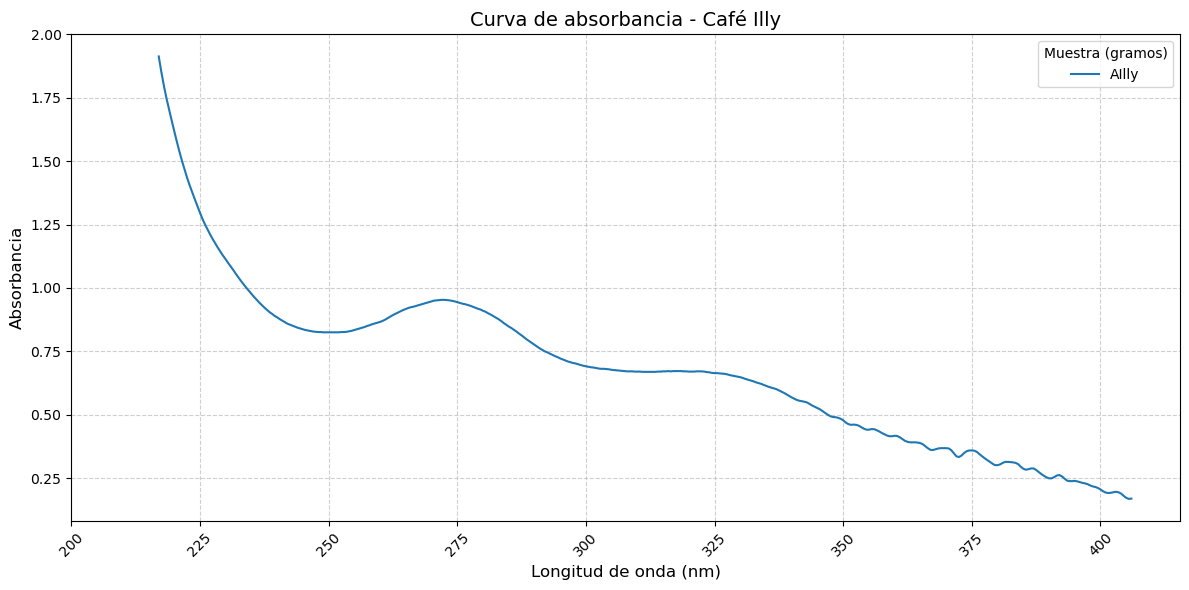

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Cargamos el archivo con las mediciones de absorbancia unidas en una matriz de datos
df = pd.read_csv("AIlly_matrix.csv")

# Limpiamos datos fuera de rango (>10)
for columna in df.columns[1:]:
    df[columna] = pd.to_numeric(df[columna], errors='coerce')
    df.loc[df[columna] > 10, columna] = None

# Obtenemos los valores máximos de cada curva
maximos = {
    columna: df[columna].max(skipna=True)
    for columna in df.columns[1:]
}

# Ordenamos de mayor a menor para que la leyenda coincida con las curvas
columnas_ordenadas = sorted(maximos, key=maximos.get, reverse=True)

# Creamos figura
plt.figure(figsize=(12, 6))

# Dibujamos las curvas ya ordenadas
for columna in columnas_ordenadas:
    plt.plot(df['nm'], df[columna], label=columna)

# Etiquetas y estilo
plt.xlabel('Longitud de onda (nm)', fontsize=12)
plt.ylabel('Absorbancia', fontsize=12)
plt.title('Curva de absorbancia - Café Illy', fontsize=14)
plt.legend(title='Muestra (gramos)', fontsize=10)
plt.xticks(df['nm'][::50], rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Graficamos la curva suavizada y ordenada por intensidad

A partir de la matriz de datos y limpia (NaN), ahora generamos una gráfica más estética y legible aplicando suavizado:

- Usamos `savgol_filter` (filtro de savitzky-golay) para suavizar la curva
- Calculamos el valor máximo de la curva suavizada
- Finalmente, graficamos con `seaborn` y `matplotlib`, usando una paleta amigable y una cuadrícula `grid(True)` para facilitar la lectura

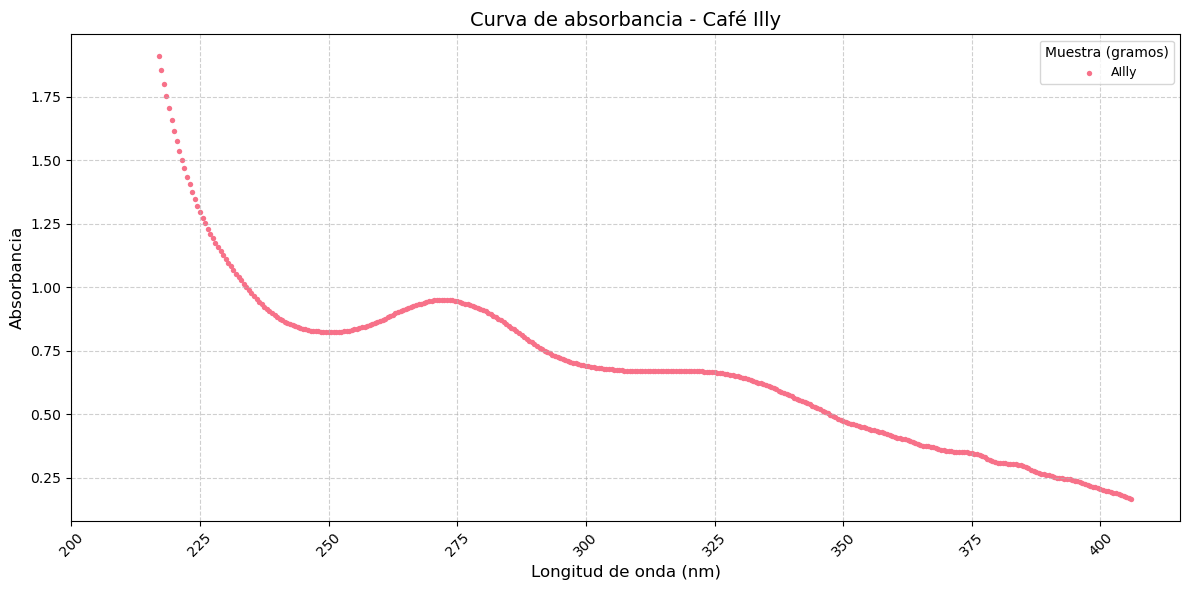

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import seaborn as sb
import numpy as np

# Cargamos la matriz de datos con las mediciones de absorbancia unidas 
df = pd.read_csv("AIlly_matrix.csv")

# Convertimos valores y descartamos saturación
for columna in df.columns[1:]:
    df[columna] = pd.to_numeric(df[columna], errors='coerce')
    df.loc[df[columna] > 10, columna] = None

# Obtenemos máximos de las curvas suavizadas
max_absorbancias = {}

for columna in df.columns[1:]:
    datos_validos = df[columna].dropna()
    if len(datos_validos) >= 21:
        y_suave = savgol_filter(datos_validos, window_length=21, polyorder=3)
        max_absorbancias[columna] = np.max(y_suave)
    else:
        max_absorbancias[columna] = -np.inf  # Muy bajo para que quede al final

# Ordenamos columnas por su valor máximo suavizado
columnas_ordenadas = sorted(max_absorbancias, key=max_absorbancias.get, reverse=True)

# Paleta de color amigable
colores = sb.color_palette("husl", len(columnas_ordenadas))

# Figura
plt.figure(figsize=(12, 6))

# Graficamos suavizado por muestra, en orden 
for i, columna in enumerate(columnas_ordenadas):
    datos_validos = df[columna].dropna()
    if len(datos_validos) >= 21:
        y_suave = savgol_filter(datos_validos, window_length=21, polyorder=3)
        x_vals = df['nm'][datos_validos.index]
        sb.scatterplot(x=x_vals, y=y_suave, s=15, label=columna, color=colores[i], linewidth=0)
    else:
        plt.plot(df['nm'], df[columna], label=columna, color=colores[i], linestyle='--')

# Estética
plt.xlabel('Longitud de onda (nm)', fontsize=12)
plt.ylabel('Absorbancia', fontsize=12)
plt.title('Curva de absorbancia - Café Illy', fontsize=14)
plt.legend(title='Muestra (gramos)', fontsize=9)
plt.xticks(df['nm'][::50], rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Suavizado de la curva con gradiente de color

Usamos ahora en este caso un gradiente de color que refleja la intensidad

- Quitamos valores saturados (>10)
- Suavizamos la curva (si hay datos suficientes)
- Ordenamos por intensidad máxima
- Dibujamos: si la curva está completa, va con gradiente; si no, con línea punteada

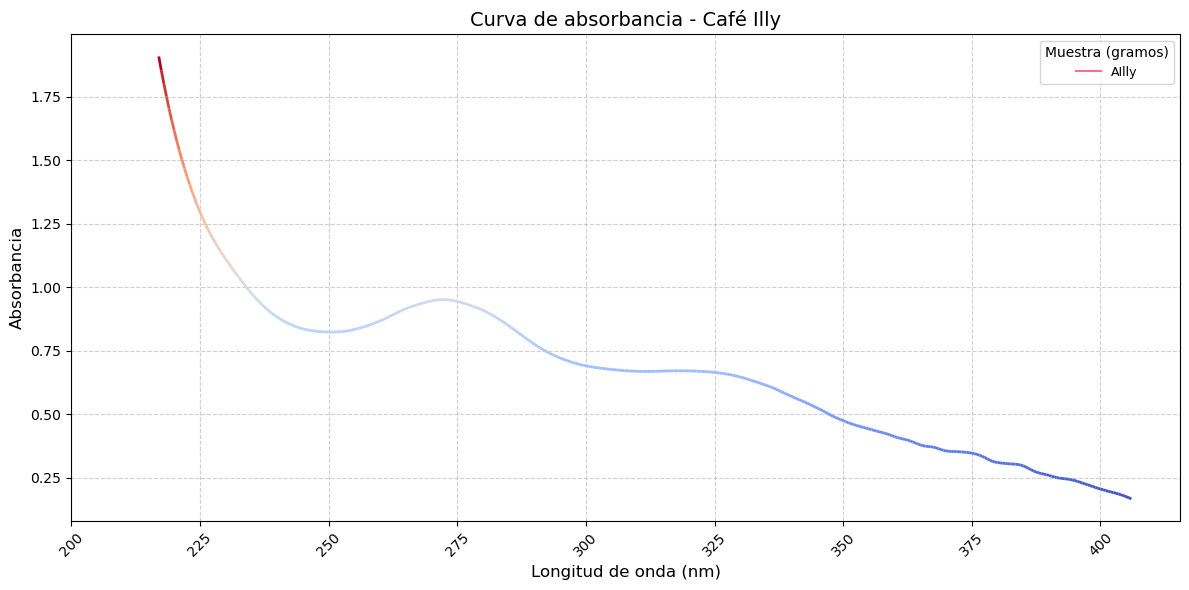

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
import seaborn as sb
import numpy as np

# Cargamos la matriz de datos con las mediciones de absorbancia unidas 
df = pd.read_csv("AIlly_matrix.csv")

# Procesamos columnas de absorbancia (excepto 'nm')
for columna in df.columns[1:]:
    df[columna] = pd.to_numeric(df[columna], errors='coerce')
    df.loc[df[columna] > 10, columna] = None

# Diccionario para guardar valores máximos de cada curva suavizada
max_absorbancias = {}

# Calculamos máximos de cada columna suavizable
for columna in df.columns[1:]:
    datos_validos = df[columna].dropna()
    if len(datos_validos) >= 21:
        y_suave = savgol_filter(datos_validos, window_length=21, polyorder=3)
        max_absorbancias[columna] = np.max(y_suave)
    else:
        max_absorbancias[columna] = np.nan  # O podemos usar max original

# Ordenamos columnas por valor máximo descendente
columnas_ordenadas = sorted(max_absorbancias, key=max_absorbancias.get, reverse=True)

# Figura principal
plt.figure(figsize=(12, 6))
plt.title("Curva de absorbancia - Café Illy", fontsize=14)

# Paleta para los colores
colores_base = sb.color_palette("husl", len(columnas_ordenadas))

# Plot
for i, columna in enumerate(columnas_ordenadas):
    datos_validos = df[['nm', columna]].dropna()

    if len(datos_validos) >= 21:
        y_suave = savgol_filter(datos_validos[columna], window_length=21, polyorder=3)
        x = datos_validos['nm'].values
        y = y_suave

        puntos = np.array([x, y]).T.reshape(-1, 1, 2)
        segmentos = np.concatenate([puntos[:-1], puntos[1:]], axis=1)

        norm = mcolors.Normalize(vmin=np.min(y), vmax=np.max(y))
        lc = LineCollection(segmentos, cmap='coolwarm', norm=norm)
        lc.set_array(y)
        lc.set_linewidth(2.0)
        plt.gca().add_collection(lc)

        plt.plot([], [], color=colores_base[i], label=columna)
    else:
        plt.plot(df['nm'], df[columna], linestyle='--', color=colores_base[i], label=columna)

# Ejes y estética
plt.xlabel("Longitud de onda (nm)", fontsize=12)
plt.ylabel("Absorbancia", fontsize=12)
plt.legend(title="Muestra (gramos)", fontsize=9)
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(df['nm'][::50], rotation=45)
plt.tight_layout()
plt.show()

In [8]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime

# === Cargar datos ===
df = pd.read_csv("AIlly_matrix.csv")

# === Limpiar valores atípicos ===
for col in df.columns[1:]:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df[col].where(df[col] <= 10)

df_clean = df.copy()

# === Definir regiones espectrales ===
regiones = {
    '100–200 nm': (100, 200),
    '200–300 nm': (200, 300),
    '300–400 nm': (300, 400),
    '400–500 nm': (400, 500),
    '500–600 nm': (500, 600)
}

# === Calcular métricas ===
resultados = []

# Iteramos sobre cada columna de absorbancia (excluyendo la primera columna 'nm')
for col in df_clean.columns[1:]:
    
    # Seleccionamos las columnas 'nm' y la muestra actual, y eliminamos filas con valores faltantes
    datos = df_clean[['nm', col]].dropna()
    
    # Extraemos el arreglo de longitudes de onda (nm)
    nm = datos['nm'].values
    
    # Extraemos el arreglo de absorbancia correspondiente a la muestra actual
    absorbancia = datos[col].values

    # Calculamos el valor máximo de absorbancia
    max_val = np.max(absorbancia)
    
    # Calculamos el valor mínimo de absorbancia
    min_val = np.min(absorbancia)
    
    # Calculamos el promedio de absorbancia
    avg = np.mean(absorbancia)
    
    # Calculamos la desviación estándar de absorbancia
    std = np.std(absorbancia)
    
    # Calculamos el área bajo la curva (AUC) mediante la regla del trapecio
    auc = np.trapezoid(absorbancia, nm)
    
    # Identificamos el valor de λ (nm) donde ocurre la máxima absorbancia
    lambda_max = nm[np.argmax(absorbancia)]
    
    # Identificamos el valor de λ (nm) donde ocurre la mínima absorbancia
    lambda_min = nm[np.argmin(absorbancia)]


    promedios_regiones = {}
    for nombre, (a, b) in regiones.items():
        datos_region = datos[(datos['nm'] >= a) & (datos['nm'] <= b)][col]
        promedio = np.mean(datos_region) if not datos_region.empty else np.nan
        promedios_regiones[nombre] = (
            f"{promedio:.6f}" if not np.isnan(promedio) else "—"
        )

    resultados.append({
        "Muestra": col,
        "Máx. Abs.": f"{max_val:.3f}",
        "Mín. Abs.": f"{min_val:.3f}",
        "Promedio": f"{avg:.3f}",
        "Desv. Estándar": f"{std:.3f}",
        "AUC": f"{auc:.2f}",
        "λ máx (nm)": f"{lambda_max:.1f}",
        "λ mín (nm)": f"{lambda_min:.1f}",
        **promedios_regiones
    })

tabla = pd.DataFrame(resultados)

# === Asegurar orden correcto usando columna numérica auxiliar ===
tabla["Máx. Abs. (num)"] = pd.to_numeric(tabla["Máx. Abs."], errors='coerce')
columnas_ordenadas = tabla.sort_values("Máx. Abs. (num)", ascending=False)["Muestra"]

# === Gráfica interactiva con Plotly ===
fig = go.Figure()
for col in columnas_ordenadas:
    datos_validos = df_clean[['nm', col]].dropna()
    fig.add_trace(go.Scatter(
        x=datos_validos['nm'],
        y=datos_validos[col],
        mode='lines',
        name=col
    ))

fig.update_layout(
    title="Curva de absorbancia - Café Illy",
    xaxis_title="Longitud de onda (nm)",
    yaxis_title="Absorbancia",
    legend_title="Muestra (gramos)",
    template="plotly_white",
    margin=dict(l=40, r=40, t=80, b=40),
)

# === Exportar HTML ===
fecha = datetime.now().strftime("%d-%m-%Y %H:%M:%S")
grafica_html = fig.to_html(full_html=False, include_plotlyjs='cdn', config={"responsive": True})
tabla_html = tabla.drop(columns=["Máx. Abs. (num)"]).to_html(index=False, classes="styled-table", border=0)

html_final = f"""
<!DOCTYPE html>
<html lang="es">
<head>
  <meta charset="UTF-8">
  <title>Reporte de Absorbancia UV-Vis</title>
  <meta name="viewport" content="width=device-width, initial-scale=1.0">
  <style>
    body {{
      font-family: 'Segoe UI', Tahoma, sans-serif;
      margin: 40px;
      background-color: #fdfdfd;
      color: #222;
    }}
    h1 {{
      color: #111;
    }}
    h2 {{
      margin-top: 40px;
    }}
    .info {{
      margin-bottom: 20px;
    }}
    .lab {{
      margin-top: 40px;
      font-size: 0.95em;
      background-color: #f0f8ff;
      padding: 15px;
      border-left: 6px solid #009879;
    }}
    .styled-table {{
      border-collapse: collapse;
      margin-top: 20px;
      font-size: 1em;
      width: 100%;
      box-shadow: 0 0 10px rgba(0, 0, 0, 0.05);
    }}
    .styled-table thead tr {{
      background-color: #009879;
      color: #ffffff;
      text-align: left;
    }}
    .styled-table th, .styled-table td {{
      padding: 12px 15px;
      border: 1px solid #ddd;
    }}
    .styled-table tbody tr:nth-child(even) {{
      background-color: #f3f3f3;
    }}
    .conclusion {{
      margin-top: 40px;
    }}
    .plotly-graph-div {{
      width: 100% !important;
      height: auto !important;
    }}
  </style>
</head>
<body>

  <h1>Reporte de Absorbancia UV-Vis - Café Illy</h1>

  <div class="info">
    <p><strong>Fecha:</strong> {fecha}</p>
  </div>

  {grafica_html}

  <h2>Métrica espectral de la muestra</h2>
  {tabla_html}

  <div>
    <p>Los espectros obtenidos muestran perfiles característicos en función del gramaje y tipo de muestra. La evaluación de zonas espectrales permite correlacionar la respuesta óptica con la presencia de compuestos activos del café.</p>
  </div>

  <div class="lab">
    <strong>Nombre del proyecto: CafeLab</strong><br><br>
    <strong>Colaboradores:</strong><br>
    Martín Rodolfo Palomino Merino – Profesor investigador, jefe responsable del laboratorio de caracterización de materiales (FCFM-BUAP).<br>
    Lizeth Jazmín Orozco García – Colaborador principal.<br>
    Julio Alfredo Ballinas García – Colaborador del proyecto.
  </div>

</body>
</html>
"""

with open("reporte_absorbancia.html", "w", encoding="utf-8") as f:
    f.write(html_final)

print("✅ Reporte generado: reporte_absorbancia.html")

# Mostrar gráfico si estás en Jupyter o interactivo
fig.show()

print("Rango de longitudes de onda:", df['nm'].min(), "a", df['nm'].max())

✅ Reporte generado: reporte_absorbancia.html


Rango de longitudes de onda: 200.0 a 410.0
